#Objective
**I want to quantitatively compare the results when determining flow from the raw intensity data, and from the relative fluorescence data. I will make a contrived testing scenario where the exact flow is known and compare the approximated flow determined in both approaches.**

### The Engine
```python
class Model:

    def __init__(self, dim=21, thickness=5, outside=1.0, inside=10.0, calAmp=50,
                 fluctuations=0.2, noise=0.03, speed=1.0, breadth=3):

        self.params = {}
        self.params["dim"] = dim
        self.params["processThickness"] = thickness
        self.params["spikeBreadth"] = breadth
        self.params["outsideConcentration"] = outside
        self.params["insideConcentration"] = inside
        self.params["calciumAmplitude"] = calAmp
        self.params["concentrationVariance"] = fluctuations
        self.params["signalNoise"] = noise
        self.params["speed"] = speed

        self.__makeData()

    def __getitem__(self, key):

        try:
            return self.params[key]
        except:
            raise KeyError

    def __setitem__(self, key, value):

        try:
            self.params[key] = value
        except:
            raise KeyError

        self.__makeData()

    def __makeData(self):

        time = int(float(self["dim"] - self["spikeBreadth"])/self["speed"])+1
        self.data = zeros((time, self["dim"], self["dim"]))
        self.fyTrue = zeros((time, self["dim"], self["dim"]))
        self.fxTrue = zeros((time-1, self["dim"], self["dim"]))
        wall1 = self["dim"]/2 - self["processThickness"]/2
        wall2 = wall1 + self["processThickness"]
        self.data[:, :, :wall1] = self["outsideConcentration"]
        self.data[:, :, wall1:wall2] = self["insideConcentration"]
        self.data[:, :, wall2:] = self["outsideConcentration"]

        for i,frame in enumerate(self.data):
            d = int(i*self["speed"])
            frame[d:d+self["spikeBreadth"], wall1:wall2] = self["calciumAmplitude"]
            self.fyTrue[i, d:d+self["spikeBreadth"], wall1:wall2] = self["speed"]
        self.fyTrue = self.fyTrue[:-1]
        self.data += (2*random.random((time, self["dim"], self["dim"]))-1)*self.data*self["concentrationVariance"]
        self.data += (2*random.random((time, self["dim"], self["dim"]))-1)*self["signalNoise"]*self["calciumAmplitud
e"]

    def run(self):

        self.calcFlow()
        self.show()
        self.error()

    def calcFlow(self, relative=True, blur=(0,0,0), parameters=None):
        flowParams = {'pyr_scale':0.5, 'levels':3, 'winsize':7, 'iterations':3, 'poly_n':5,
                      'poly_sigma':1.1, 'flags':cv2.OPTFLOW_FARNEBACK_GAUSSIAN}
        flowParams = parameters if parameters else flowParams
        frames, h, w = self.data.shape
        self.xflow = ndarray((frames-1,h,w))
        self.yflow = ndarray((frames-1,h,w))

        data = self.data
        if relative:
            f0 = percentile(self.data,10,0);
            plt.imshow(f0, cmap='gray', interpolation='nearest', vmin=f0.min(), vmax=f0.max())
            plt.title("F0"); plt.colorbar()
            data = (self.data-f0)/f0

        blurData = gauss(data, blur)
        prev = self.data[0]
        for i,curr in enumerate(blurData[1:]):
            flow = cv2.calcOpticalFlowFarneback(prev, curr, **flowParams)
            self.xflow[i] = flow[:,:,0]
            self.yflow[i] = flow[:,:,1]
            prev = curr

    def show(self, frames=[0,None], cols=3, parameters=None):
        vecParams = {'pivot':'tail', 'angles':'xy', 'scale_units':'xy', 'color':'yellow'}
        vecParams = parameters if parameters else vecParams

        if type(frames) == int:
            plt.figure(figsize=(12,12))
            plt.imshow(self.data[frames], cmap='gray')
            plt.quiver(self.xflow[frames], self.yflow[frames], **vecParams)
            return
        else:
            vmin = self.data.min()
            vmax = self.data.max()
            begf, endf = frames
            endf = endf if endf else len(self.xflow)
            rows = int(ceil((endf-begf)/float(cols)))
            fw = 13; fh = float(rows*fw)/cols
            plt.figure(figsize=(fw, fh))
            for i in range(begf, endf):
                plt.subplot(rows,cols,i-begf+1)
                plt.imshow(self.data[i], cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax); plt.colorbar()
                plt.title("Flow from frame %d to frame %d" % (i,i+1))
                plt.quiver(self.xflow[i], self.yflow[i], **vecParams)
        plt.tight_layout()

    def error(self):

        trueNorms = sqrt(self.fxTrue**2 + self.fyTrue**2)
        approxNorms = sqrt(self.xflow**2 + self.yflow**2)
        maxErr = trueNorms + approxNorms
        maxErr[abs(maxErr) < 1e-12] = 1.0
        err = sqrt((self.fxTrue-self.xflow)**2 + (self.fyTrue-self.yflow)**2)/maxErr
        print "Maximum Point-wise Error = ", err.max()
        print "Minimum Point-wise Error = ", err.min()
        frob = linalg.norm(err,'fro',(1,2))
        print "Maximum Frobenius Norm = ", frob.max()
        print "Minimum Frobenius Norm = ", frob.min()
        totErr = average(frob)
        print "Total Error = ", totErr
        return totErr
```

###How to Use it

In [1]:
from model import Model
import matplotlib
%matplotlib inline 

---
###Test 1
Look at relative calcium concentrations...

In [2]:
M = Model(dim=21, thickness=3, speed=1, fluctuations=0, noise=0, breadth=2)

In [3]:
M.calcFlow(relative=False)

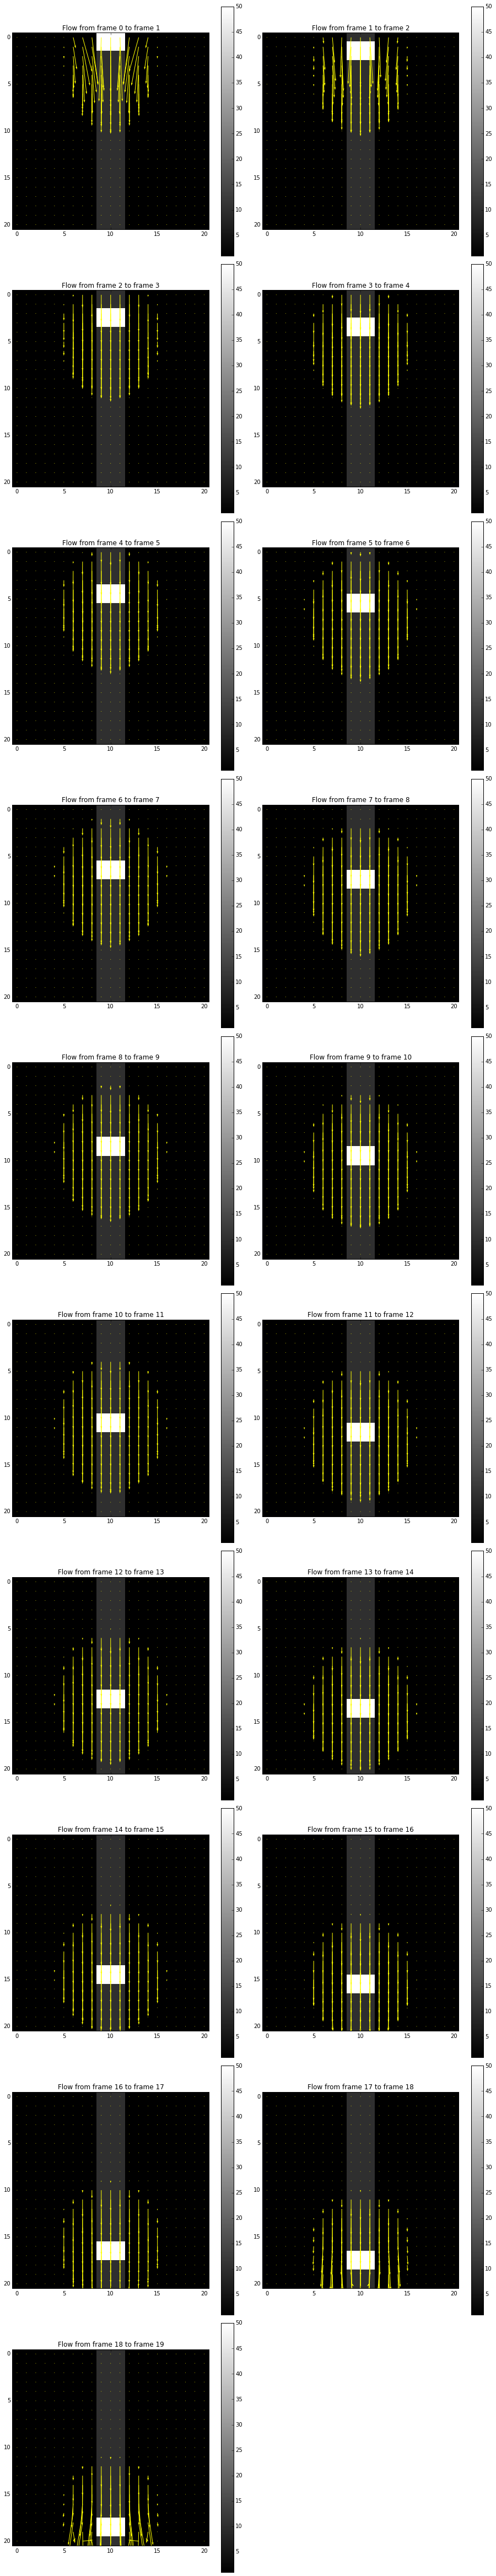

In [4]:
M.show(cols=2)

In [5]:
M.error()

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.0
Maximum Frobenius Norm =  17.9722018347
Minimum Frobenius Norm =  13.5703520551
Total Error =  15.8551205925


15.855120592513829

In [9]:
M['processThickness'] = 7

In [10]:
M.calcFlow(relative=False)

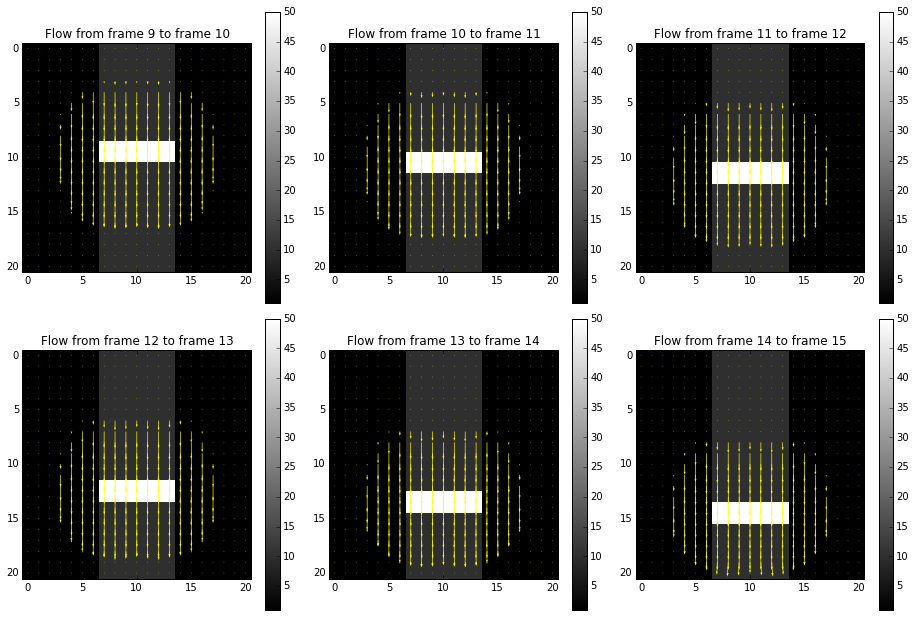

In [12]:
M.show(cols=3, frames=[9,15])

In [15]:
M['speed'] = 2

Maximum Point-wise Error =  1.0
Minimum Point-wise Error =  0.0
Maximum Frobenius Norm =  16.2779393987
Minimum Frobenius Norm =  13.7952769121
Total Error =  15.4701857432


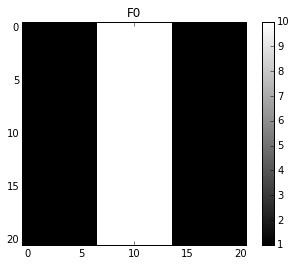

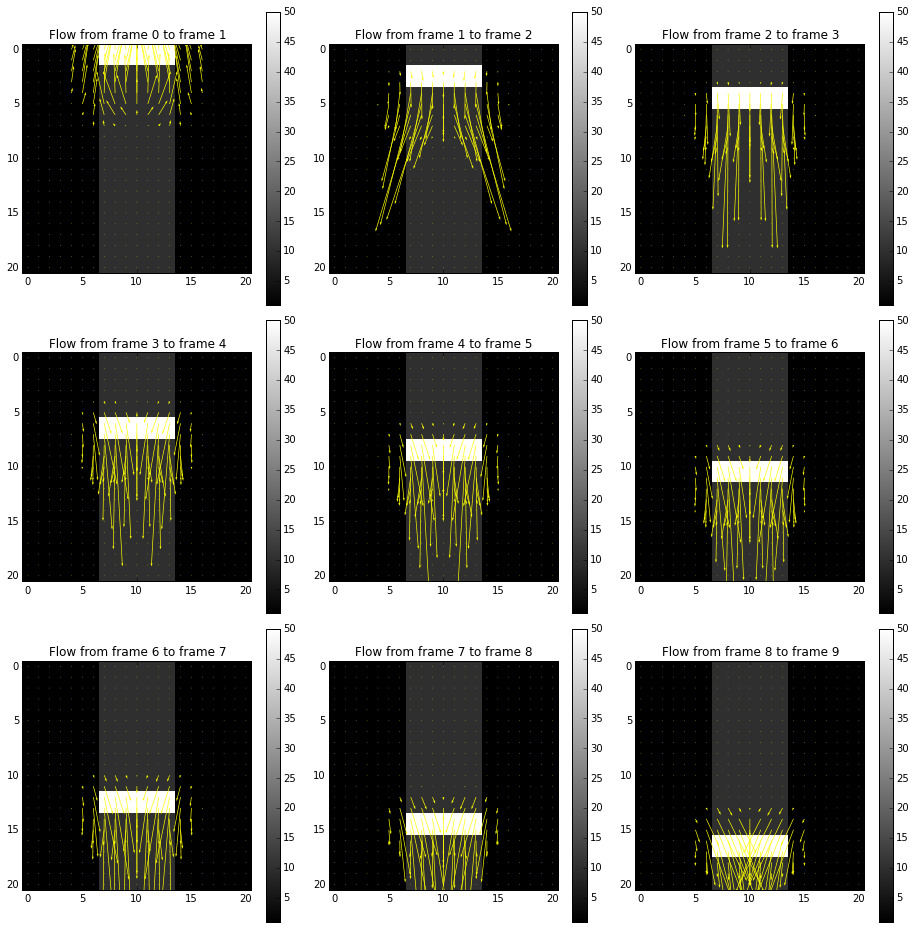

In [16]:
M.run()